# Pseudotime Enrichment Analysis

Analyzing omics data is not always as straightforward as comparing observations between two discrete groups,
such as treatment against control.
In some cases, the biological context exhibits a continuous nature, such as cell differentiation,
disease progression, or developmental stages.
In these scenarios, it is important to assess how features change along the continuous process and how
enrichment scores that summarize these features vary across this axis.

This notebook demonstrates the use of `decoupler` to infer transcription factor (TF)
and pathway enrichment scores from a mouse scRNA-seq dataset.

The dataset includes 1k donwsampled cells from the erytroid lineage during mouse gastrulation {cite:p}`erygast`,
a continuous process that can be characterized by the inferrence of pseudotime.

## Loading Packages

In [1]:
import numpy as np

import scanpy as sc
import decoupler as dc

sc.set_figure_params(figsize=(3, 3), frameon=False)

## Loading The Dataset

In [2]:
adata = dc.ds.erygast1k()
adata

AnnData object with n_obs × n_vars = 801 × 8124
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    uns: 'celltype_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'

The obtained {class}`anndata.AnnData` consist of log-normalized transcript counts for ~1k cells
with measurements for ~8k genes.

The cell metadata stored in {attr}`anndata.AnnData.obs` can be inspected.

In [3]:
adata.obs

,sample,stage,sequencing.batch,theiler,celltype
GTGGATTGCGTCTC,29,E8.5,3,TS12,Erythroid1
ACTGCCTGAACGGG,12,E7.75,2,TS11,Blood progenitors 2
TCCACTCTCTTCGC,36,E8.5,3,TS12,Erythroid3
GCAGCCGAGTGTTG,20,E7.5,2,TS11,Blood progenitors 2
GATCCCTGATCGTG,37,E8.5,3,TS12,Erythroid3
...,...,...,...,...,...
GACATTCTGGAACG,13,E7.75,2,TS11,Blood progenitors 2
ACAAATTGCGTGTA,36,E8.5,3,TS12,Erythroid3
TGCACGCTAACGTC,37,E8.5,3,TS12,Erythroid3
GCAGTTGAGGTTAC,16,E8.0,2,TS12,Erythroid1


And visualized.

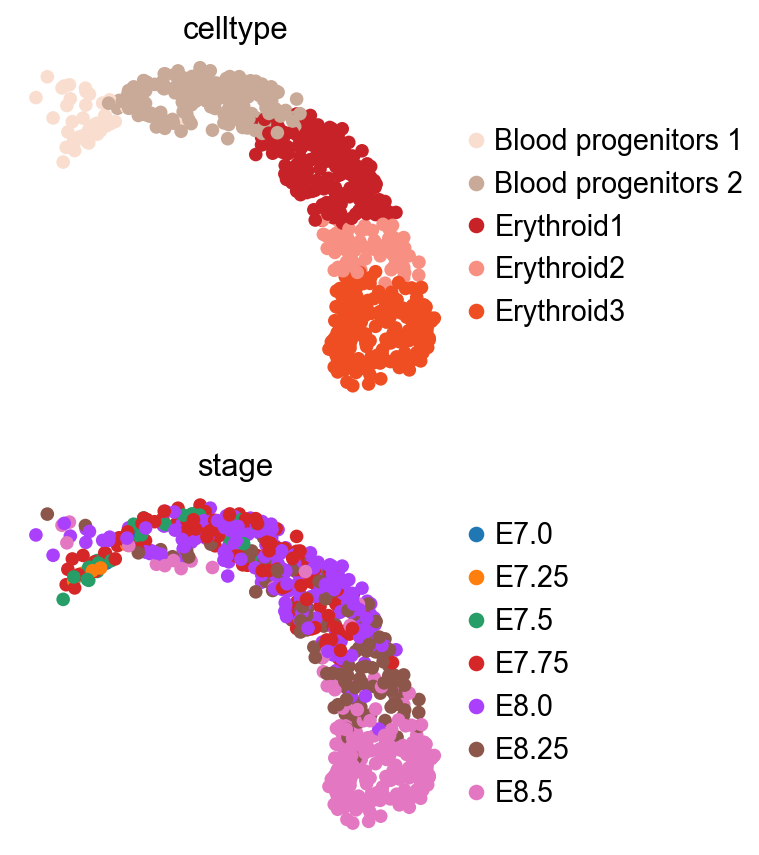

In [4]:
sc.pl.umap(adata, color=['celltype', 'stage'], ncols=1)

## Pseudotime inference

Pseudotime inference estimates the progression of cells along a continuous trajectory
based on their proximity in a low-dimensional space derived from molecular readouts,
in this case, gene expression.

It requires a defined starting point, typically based on prior biological knowledge of the tissue under study.

In this case, the trajectory is known to originate from the "Blood Progenitors 1" cell type.
The following demonstrates how to infer pseudotime using `paga` {cite:p}`paga`.

<div class="alert alert-info">

**Note**

In some cases, pseudotime calculation is not necessary, as information about the continuous process of
interest may already be available in the metadata or inferred through alternative methods,
such as factor scoring in `mofacell` {cite:p}`mofacell`.
</div>

In [5]:
root_celltype = "Blood progenitors 1"

sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, use_rep="X_diffmap")
sc.tl.paga(adata, groups="celltype")
iroot = np.flatnonzero(adata.obs["celltype"] == root_celltype)[0]
adata.uns["iroot"] = iroot
sc.tl.dpt(adata)

Then, he obtained graph of cell types and the predicted pseudotime can be visualized.

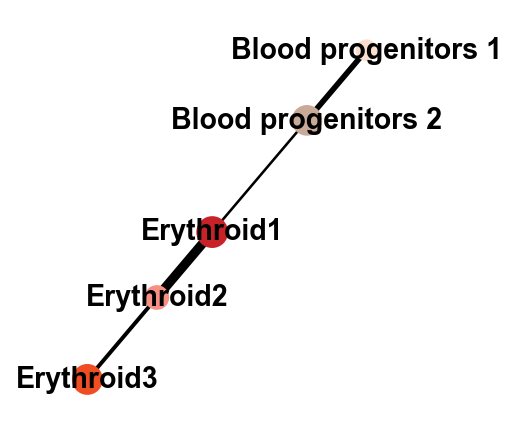

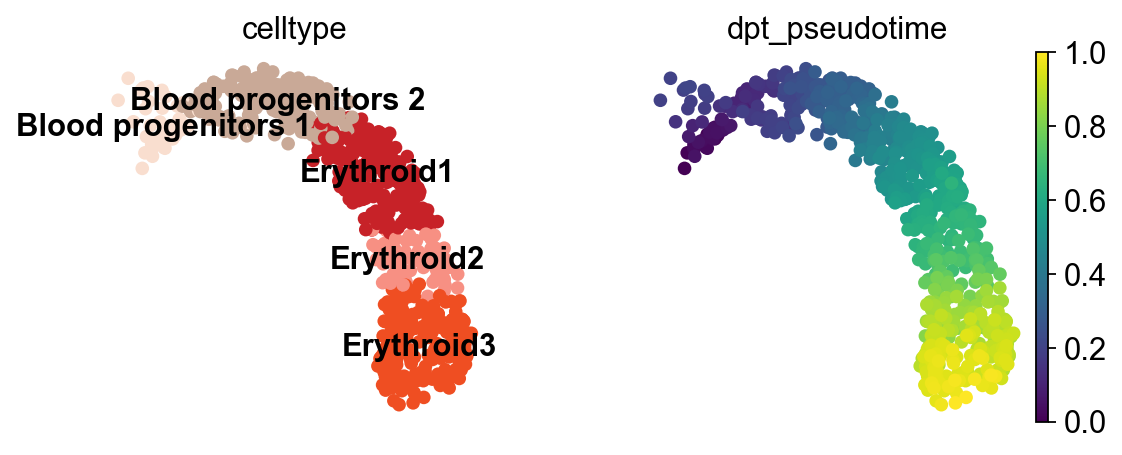

In [6]:
sc.pl.paga(adata, color=["celltype"])
sc.pl.umap(adata, color=["celltype", "dpt_pseudotime"], legend_loc="on data")

As expected, the predicted pseudotime orders cells from "Blood progenitors 1" to "Erythroid3".

## Enrichment analysis

Enrichment analysis tests whether a specific set of omics features is "overrepresented" or "coordinated"
in the measured data compared to a background distribution. These sets are predefined based on existing
biological knowledge and may vary depending on the omics technology used.

Enrichment analysis requires the use of an enrichment method, and several options are available.
In the original manuscript of `decoupler` {cite:p}`decoupler`, we benchmarked multiple methods
and found that the univariate linear model (`ulm`) outperformed the others. Therefore, we will use
`ulm` in this vignette. 

The scores from {func}`decoupler.mt.ulm` should be interpreted such that larger magnitudes indicate
greater significance, while the sign reflects whether the features in the set are overrepresented
(positive) or underrepresented (negative) compared to the background.

### Transcription factor scoring from gene regulatory networks

Transcription factors (TFs) are genes that, once translated into proteins, bind to DNA and regulate
the expression of other genes by either promoting or inhibiting their transcription. Gene
Regulatory Networks (GRNs) capture these TF-gene interactions and can be constructed from prior
knowledge or inferred from omics data. The fundamental unit of a GRN is a TF and its associated target
genes, collectively known as a *regulon*. Each regulon functions as a gene set in enrichment analysis.

Although TFs are measured in transcriptomic data, their transcript levels often do not reflect their actual
activity in a given cell. Instead, scoring TFs through enrichment analysis based on the expression of
their target genes provides a more accurate representation of their regulatory activity
{cite:p}`grn_review`.

#### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource containing a curated
collection of TFs and their transcriptional targets compiled from 12 different resources {cite:p}`collectri`. This collection
provides an increased coverage of transcription factors and a superior performance in identifying perturbed
TFs compared to other literature based GRNs such as 
[DoRothEA](https://saezlab.github.io/dorothea/) {cite:p}`dorothea`.
Similar to DoRothEA, interactions are weighted by their mode of regulation
(activation or inhibition).

In this tutorial we will use the mouse version but other organisms are available.
We can use `decoupler` to retrieve it from the [OmniPath](https://omnipathdb.org/) server {cite:p}`omnipath`.

<div class="alert alert-info">

**Note**
In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 
</div> 

In [7]:
collectri = dc.op.collectri(organism='mouse')
collectri

,source,target,weight,resources,references,sign_decision
0,Myc,Tert,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,Spi1,Bglap3,1.0,ExTRI,10022617,default activation
2,Spi1,Bglap,1.0,ExTRI,10022617,default activation
3,Spi1,Bglap2,1.0,ExTRI,10022617,default activation
4,Smad3,Jun,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
...,...,...,...,...,...,...
43221,Runx1,Lcp2,1.0,DoRothEA-A,20019798,default activation
43222,Runx1,Prr5l,1.0,DoRothEA-A,20019798,default activation
43223,Twist1,Gli1,1.0,DoRothEA-A,11948912,default activation
43224,Usf1,Nup188,1.0,DoRothEA-A,22951020,PMID


#### Scoring
TF scores can be easily computed by running the `ulm` method.

In [8]:
dc.mt.ulm(data=adata, net=collectri)

Scores can then be extracted as a new `anndata.AnnData` object.

In [9]:
score = dc.pp.get_obsm(adata=adata, key='score_ulm')
score

AnnData object with n_obs × n_vars = 801 × 513
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'dpt_pseudotime'
    uns: 'celltype_colors', 'log1p', 'stage_colors', 'neighbors', 'diffmap_evals', 'paga', 'celltype_sizes', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap', 'score_ulm', 'padj_ulm'

And visualized.

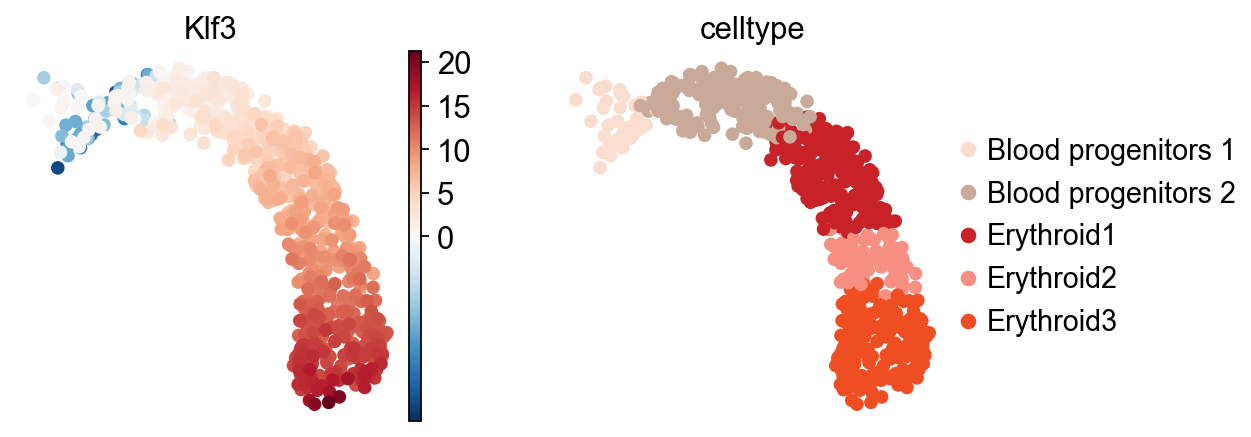

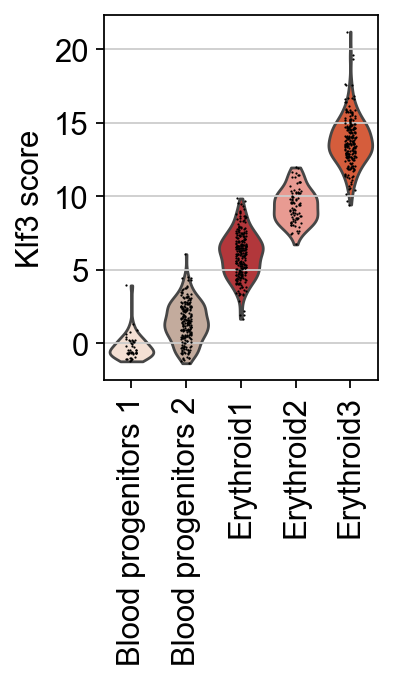

In [10]:
tf = 'Klf3'
sc.pl.umap(score, color=[tf, 'celltype'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(score, keys=[tf], groupby='celltype', rotation=90, ylabel=f'{tf} score')

Here, the inferred activity of Klf3 across cells is shown, with an increasing value along the trajectory.
Notably, Klf3 is a well-established TF essential in erythroid lineage specification and maturation.

As previously noted, TF expression alone is not a reliable proxy for its activity.
For instance, although Klf3 is known to activate during the comitement towards the erythroid lineage,
its expression is detected in only a limited number of cells in this dataset.
This highlights the importance of using TF enrichment scores.

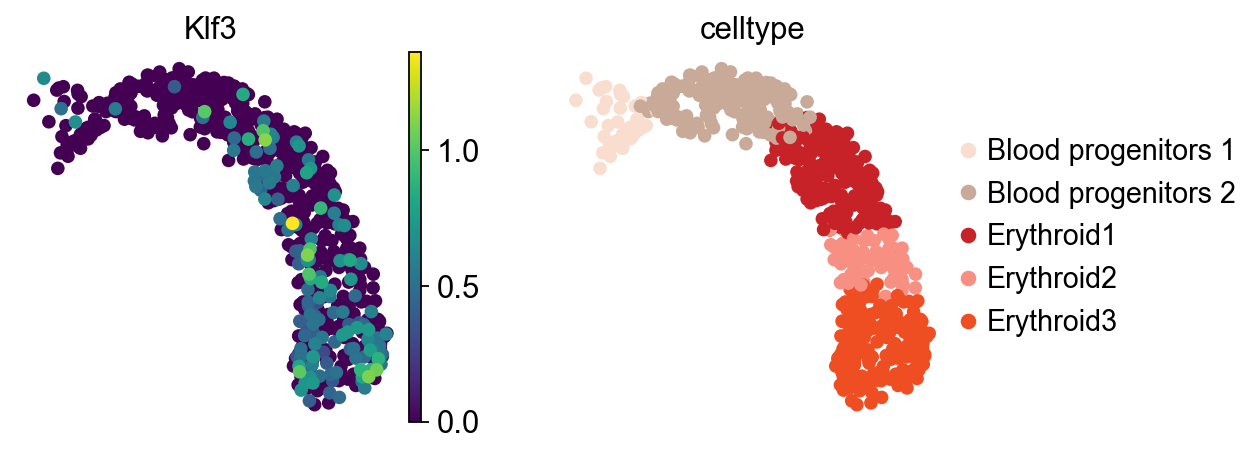

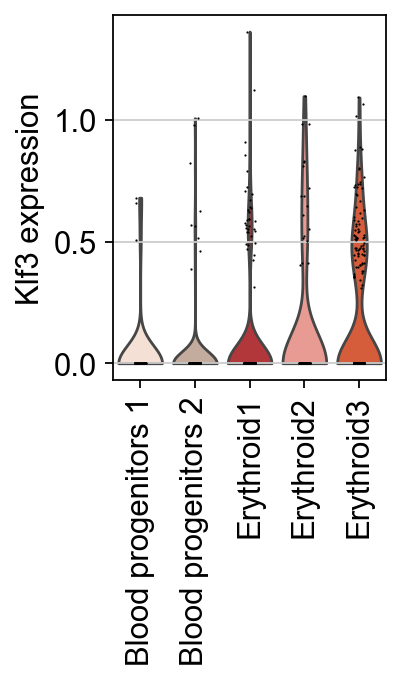

In [11]:
sc.pl.umap(adata, color=[tf, 'celltype'])
sc.pl.violin(adata, keys=[tf], groupby='celltype', rotation=90, ylabel=f'{tf} expression')

Next, TFs associated with the inferred pseudotime can be identified.

In [12]:
tfs = dc.tl.rankby_order(
    adata=score,
    order='dpt_pseudotime',
)
tfs

,name,impr,corr,pval,padj,sign
0,Klf3,0.408564,0.974839,0.000000e+00,0.000000e+00,1
1,Klf1,0.341750,0.970889,0.000000e+00,0.000000e+00,1
2,Hoxb6,0.110489,-0.975827,0.000000e+00,0.000000e+00,-1
3,Nfe2,0.026748,0.967313,0.000000e+00,0.000000e+00,1
4,Atrx,0.005803,-0.966574,0.000000e+00,0.000000e+00,-1
...,...,...,...,...,...,...
508,Mxd1,0.000000,-0.562862,3.957816e-68,2.360883e-67,-1
509,Eno1b,0.000000,-0.302229,2.217547e-18,5.340852e-18,-1
510,Mycs,0.000000,-0.578006,1.386252e-72,9.001866e-72,-1
511,Srsf2,0.000000,-0.520843,6.698927e-57,3.436549e-56,-1


The top 5 TF markers associated to the pseudotime can then be extracted.

In [13]:
top_tfs = tfs.head(5)['name'].to_list()
top_tfs

['Klf3', 'Klf1', 'Hoxb6', 'Nfe2', 'Atrx']

And visualized.

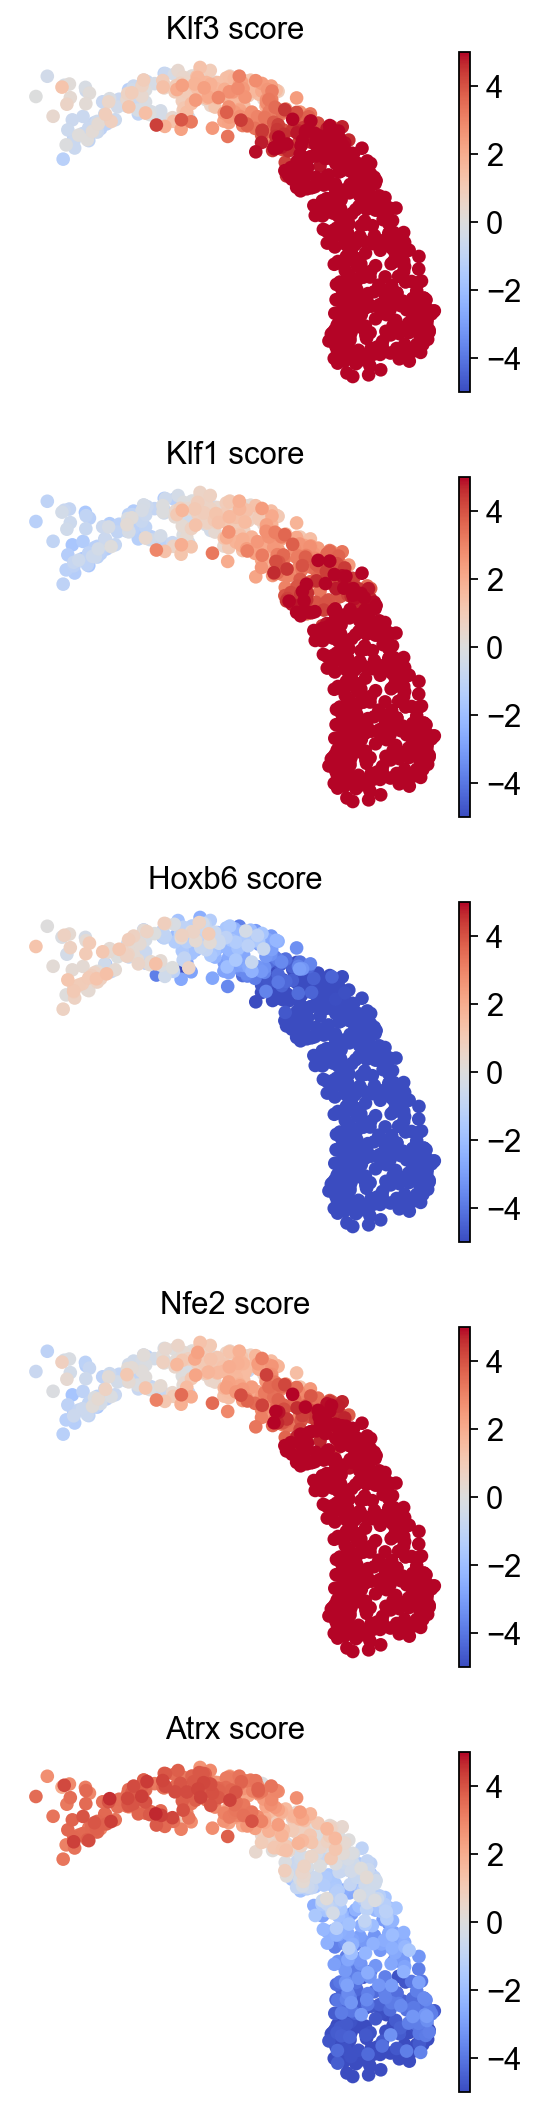

In [14]:
sc.pl.umap(
    score,
    color=top_tfs,
    cmap='coolwarm',
    vmin=-5,
    vmax=5,
    ncols=1,
    title=[f'{t} score' for t in top_tfs]
)

Prior to generating more complex visualizations,
cells are grouped into bins based on their ordering to facilitate plotting.

In [15]:
bin_tfs = dc.pp.bin_order(
    adata=score,
    order='dpt_pseudotime',
    names=top_tfs,
    label='celltype',
)
bin_tfs

,name,order,value,label,color
0,Klf3,0.005025,-1.236535,Blood progenitors 1,#f9decf
1,Klf3,0.005025,-0.073794,Blood progenitors 1,#f9decf
2,Klf3,0.005025,-0.685060,Blood progenitors 1,#f9decf
3,Klf3,0.005025,-0.678414,Blood progenitors 1,#f9decf
4,Klf3,0.015075,-0.701368,Blood progenitors 1,#f9decf
...,...,...,...,...,...
4000,Atrx,0.989950,-6.894305,Erythroid3,#EF4E22
4001,Atrx,0.989950,-4.275815,Erythroid3,#EF4E22
4002,Atrx,1.000000,-5.932188,Erythroid3,#EF4E22
4003,Atrx,1.000000,-7.659520,Erythroid3,#EF4E22


Which can be plotted as lines.

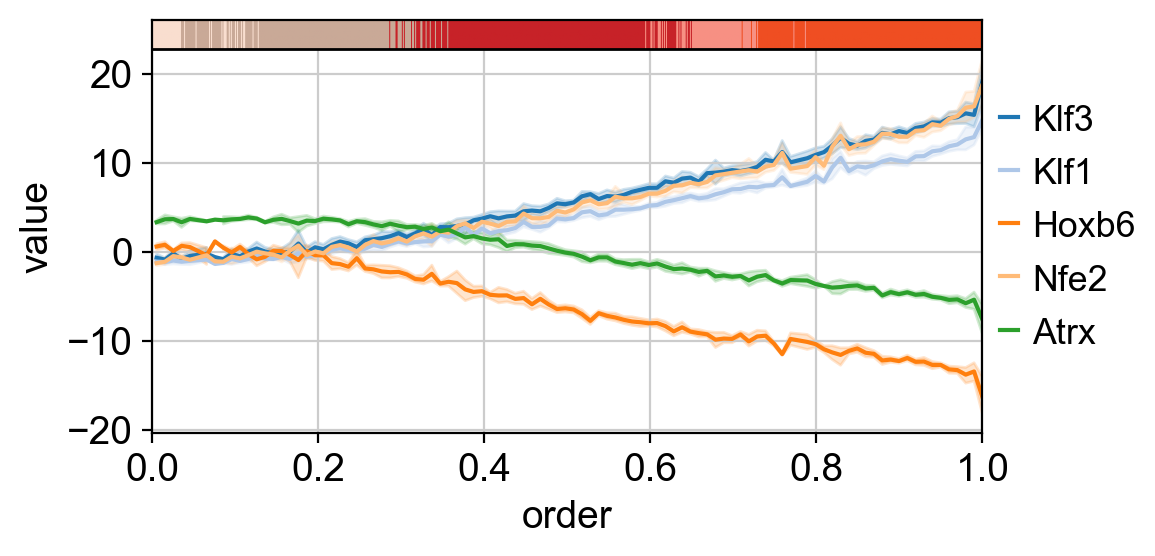

In [16]:
dc.pl.order(
    df=bin_tfs,
    mode='line',
    figsize=(6, 3),
)

Or as a matrix.

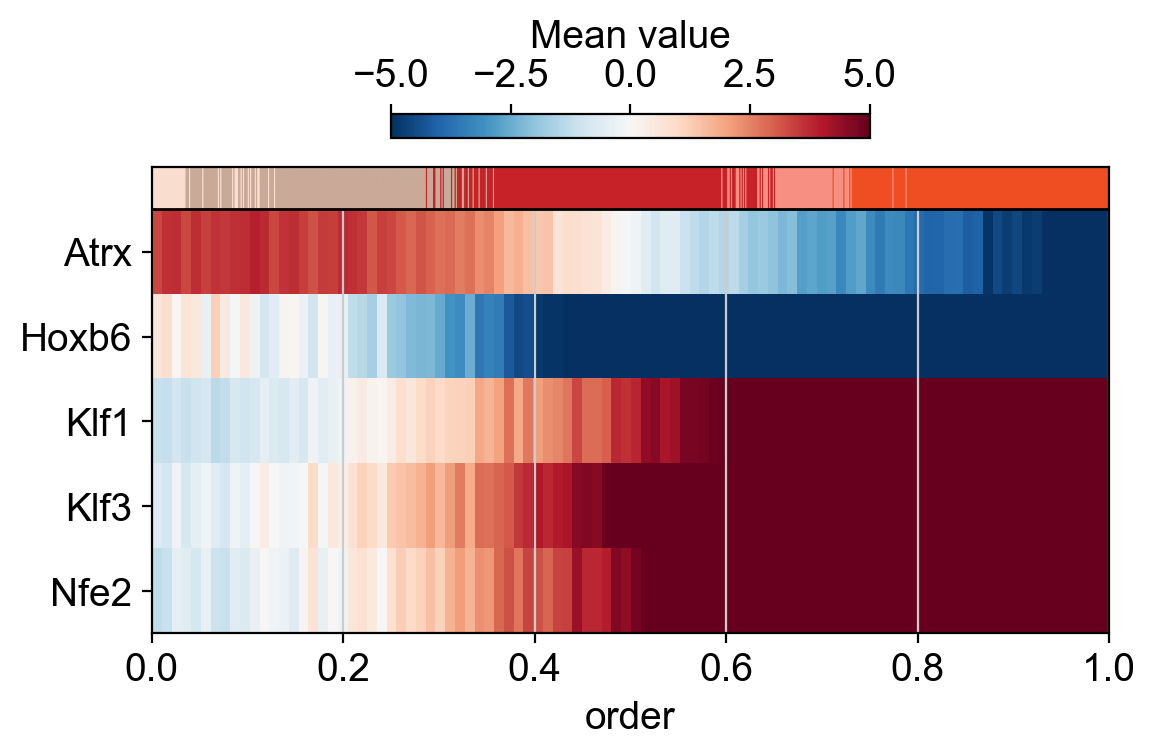

In [17]:
dc.pl.order(
    df=bin_tfs,
    mode='mat',
    kw_order=dict(vmin=-5, vmax=+5, cmap='RdBu_r'),
    figsize=(6, 4)
)

TFs relevant to progenitor cells, such as Atrx and Hoxb6, are active at the beginning of the trajectory.
In contrast, TFs involved in commitment to the erythroid lineage, such as the Klf family,
are initially inactive but become activated along the trajectory.

Individual TFs can be examined by plotting their score distributions.

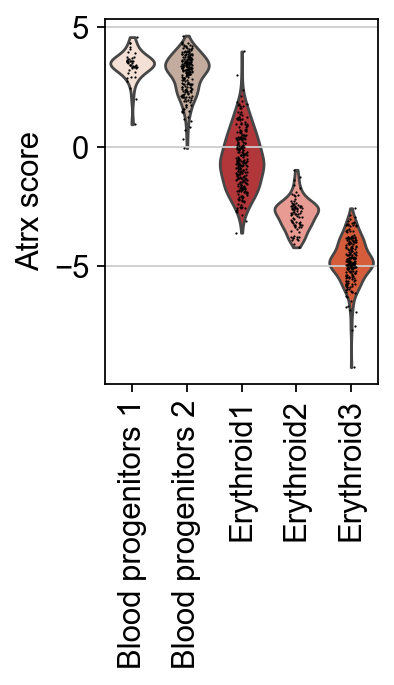

In [18]:
tf = 'Atrx'
sc.pl.violin(score, keys=[tf], groupby='celltype', rotation=90, ylabel=f'{tf} score')

Additionally, to better understand the obtained enrichment scores,
the targets of a specified TF can be plotted along the trajectory.

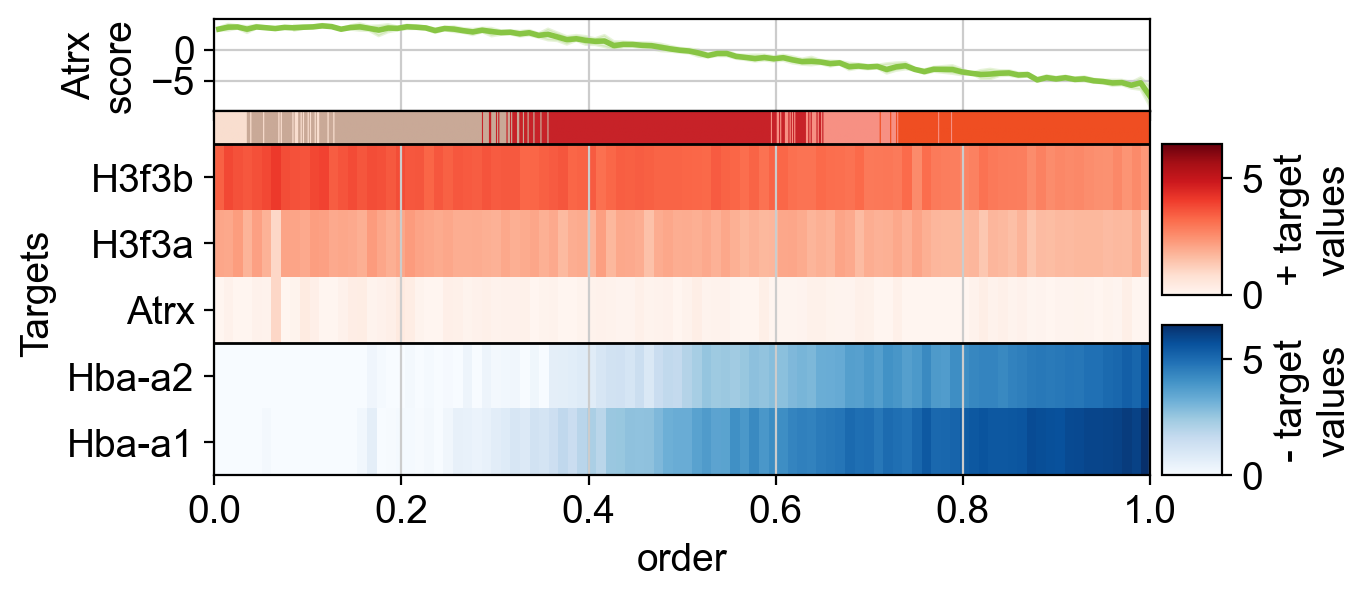

In [19]:
dc.pl.order_targets(
    adata=adata,
    net=collectri,
    label='celltype',
    source='Atrx',
    order='dpt_pseudotime',
)

The change in the enrichment score results from positive targets of Atrx decreasing in expression,
while its repressed targets increase in expression along the trajectory.
Consequently, the TF is active at the beginning but becomes inactive by the end.

### Pathway Scoring

The same approach used for TF scoring can also be applied to pathways. Numerous
databases provide curated pathway gene sets, with one of the most well-known being MSigDB, which
includes several collections {cite:p}`msigdb`. 
These and many other resources can be accessed using the function {func}`decoupler.op.resource`.
To view the list of available databases, use {func}`decoupler.op.show_resources`.

#### PROGENy Pathway Genes
[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource that provides a curated
collection of pathways and their target genes, along with weights for each interaction
{cite:p}`progeny`.

Below is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation
- **MAPK**: integrates external signals and promotes cell growth and proliferation
- **NFkB**: regulates immune response, cytokine production and cell survival
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression
- **PI3K**: promotes growth and proliferation
- **TGFb**: involved in development, homeostasis, and repair of most tissues
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection
- **Trail**: induces apoptosis
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration
- **WNT**: regulates organ morphogenesis during development and tissue repair

This is how to access to it.

In [20]:
progeny = dc.op.progeny(organism='mouse')
progeny

,source,target,weight,padj
0,Androgen,Tmprss2,11.490631,2.384806e-47
1,Androgen,Nkx3-1,10.622551,2.205102e-44
2,Androgen,Mboat2,10.472733,4.632376e-44
3,Androgen,Slc38a4,7.363805,1.253071e-39
4,Androgen,Mtmr9,6.130646,2.534403e-38
...,...,...,...,...
60572,p53,Enpp2,2.771405,4.993215e-02
60573,p53,Arrdc4,3.494328,4.996747e-02
60574,p53,Myo1b,-1.148057,4.997905e-02
60575,p53,Ctsc,-1.784693,4.998864e-02


#### Scoring
Pathway scores can be easily computed by running the `ulm` method.

In [21]:
dc.mt.ulm(data=adata, net=progeny)

Scores can then be extracted.

In [22]:
score = dc.pp.get_obsm(adata=adata, key='score_ulm')
score

AnnData object with n_obs × n_vars = 801 × 14
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'dpt_pseudotime'
    uns: 'celltype_colors', 'log1p', 'stage_colors', 'neighbors', 'diffmap_evals', 'paga', 'celltype_sizes', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap', 'score_ulm', 'padj_ulm'

And visualized.

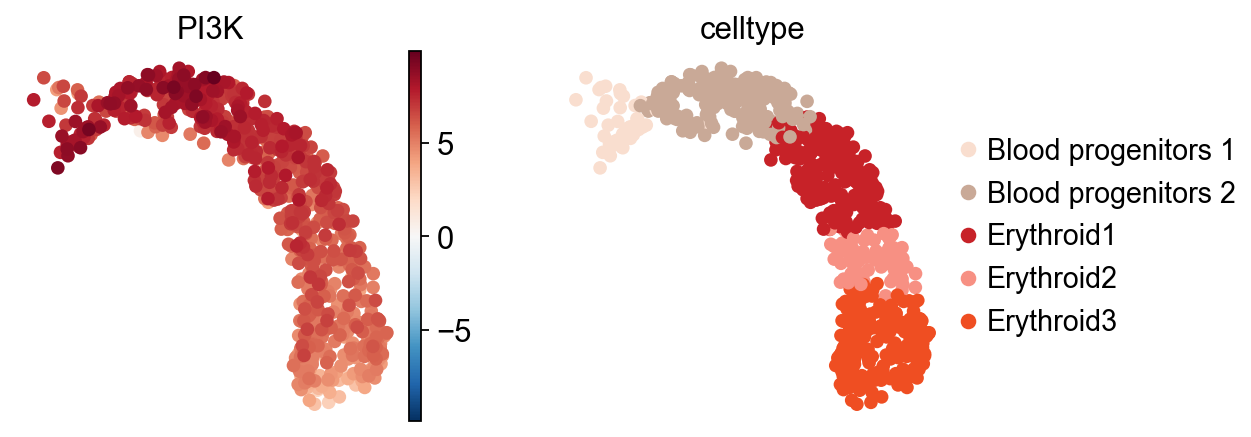

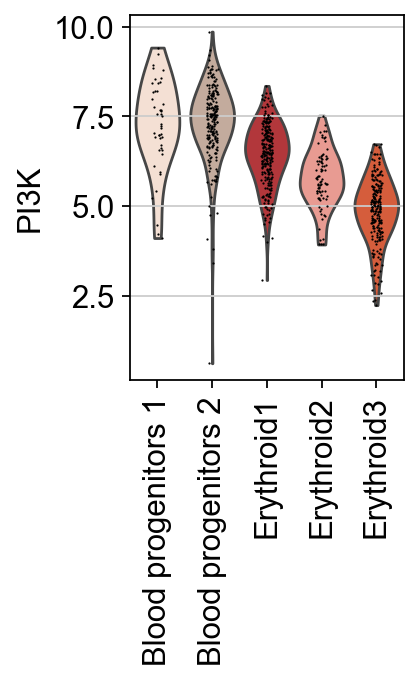

In [23]:
sc.pl.umap(score, color=['PI3K', 'celltype'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(score, keys=['PI3K'], groupby='celltype', rotation=90)

Next, the association between pathways and the trajectory can be tested.

In [24]:
pws = dc.tl.rankby_order(
    adata=score,
    order='dpt_pseudotime',
)
pws

,name,impr,corr,pval,padj,sign
0,PI3K,0.584963,-0.711521,1.410567e-124,1.974793e-123,-1
1,NFkB,0.098003,-0.371091,1.484557e-27,3.463967e-27,-1
2,EGFR,0.056188,-0.653843,7.282385e-99,5.097670e-98,-1
3,MAPK,0.056014,-0.613235,6.644825e-84,3.100918e-83,-1
4,Hypoxia,0.055408,-0.021201,5.490746e-01,5.490746e-01,0
5,Estrogen,0.026518,-0.322832,6.939623e-21,9.715472e-21,-1
6,JAK-STAT,0.024068,-0.267422,1.388895e-14,1.620377e-14,-1
7,WNT,0.023181,0.367319,5.438453e-27,1.087691e-26,1
8,TGFb,0.023139,-0.451259,1.942507e-41,5.439020e-41,-1
9,VEGF,0.013023,-0.451758,1.548044e-41,5.418154e-41,-1


And plotted.

In [25]:
bin_pws = dc.pp.bin_order(
    adata=score,
    order='dpt_pseudotime',
    names=pws.head(5)['name'].to_list(),
    label='celltype',
)
bin_pws

,name,order,value,label,color
0,PI3K,0.005025,9.238632,Blood progenitors 1,#f9decf
1,PI3K,0.005025,7.656678,Blood progenitors 1,#f9decf
2,PI3K,0.005025,7.569328,Blood progenitors 1,#f9decf
3,PI3K,0.005025,6.936269,Blood progenitors 1,#f9decf
4,PI3K,0.015075,8.850726,Blood progenitors 1,#f9decf
...,...,...,...,...,...
4000,Hypoxia,0.989950,-9.132397,Erythroid3,#EF4E22
4001,Hypoxia,0.989950,-9.353291,Erythroid3,#EF4E22
4002,Hypoxia,1.000000,-7.467456,Erythroid3,#EF4E22
4003,Hypoxia,1.000000,-7.330334,Erythroid3,#EF4E22


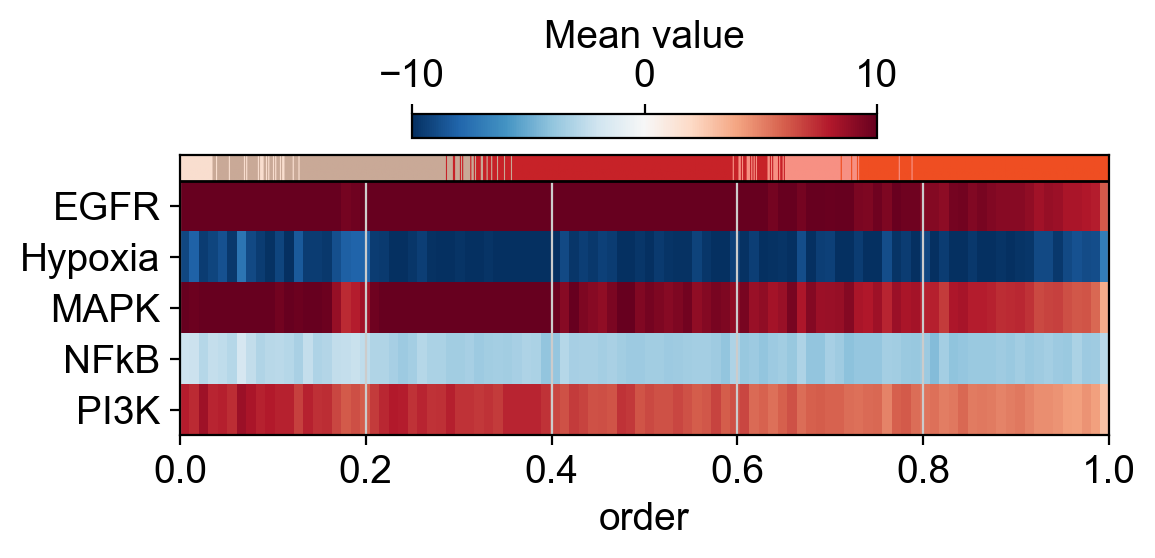

In [26]:
dc.pl.order(
    df=bin_pws,
    mode='mat',
    kw_order=dict(vmin=-10, vmax=+10, cmap='RdBu_r'),
    figsize=(6, 3)
)

It seems that along the trajectory there are no big changes,
just a mild decrease of PI3K activity.

#### Hallmark gene sets
[Hallmark](https://www.gsea-msigdb.org/gsea/msigdb/human/collection_details.jsp#H)
gene sets are curated collections of genes that represent specific, well-defined biological states or processes.
They are part of MSigDB and were developed to reduce redundancy and improve interpretability compared to older,
more overlapping gene set collections {cite:p}`msigdb`.

A total of 50 gene sets are provided, designed to be non-redundant, concise, and biologically coherent.

This is how to access them.

In [27]:
hallmark = dc.op.hallmark(organism='mouse')
hallmark

,source,target
0,IL2_STAT5_SIGNALING,Maff
1,COAGULATION,Maff
2,HYPOXIA,Maff
3,TNFA_SIGNALING_VIA_NFKB,Maff
4,COMPLEMENT,Maff
...,...,...
7606,PANCREAS_BETA_CELLS,Stxbp1
7607,PANCREAS_BETA_CELLS,Elp4
7608,PANCREAS_BETA_CELLS,Gcg
7609,PANCREAS_BETA_CELLS,Pcsk2


#### Scoring
Pathway scores can be easily computed by running the `ulm` method.

In [28]:
dc.mt.ulm(data=adata, net=hallmark)

Scores can be then extracted.

In [29]:
score = dc.pp.get_obsm(adata=adata, key='score_ulm')
score

AnnData object with n_obs × n_vars = 801 × 50
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'dpt_pseudotime'
    uns: 'celltype_colors', 'log1p', 'stage_colors', 'neighbors', 'diffmap_evals', 'paga', 'celltype_sizes', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap', 'score_ulm', 'padj_ulm'

Tested for association to the trajectory.

In [30]:
hlm = dc.tl.rankby_order(
    adata=score,
    order='dpt_pseudotime',
)
hlm.head()

,name,impr,corr,pval,padj,sign
0,HEME_METABOLISM,0.930335,0.964032,0.000000e+00,0.000000e+00,1
1,INTERFERON_ALPHA_RESPONSE,0.003057,-0.000492,9.889063e-01,9.889063e-01,0
2,PI3K_AKT_MTOR_SIGNALING,0.002868,-0.601062,7.823439e-80,5.588171e-79,-1
3,OXIDATIVE_PHOSPHORYLATION,0.002618,0.579060,6.652355e-73,3.695753e-72,1
4,APICAL_JUNCTION,0.002524,-0.695932,5.047259e-117,6.309073e-116,-1


And plotted.

In [31]:
bin_hlm = dc.pp.bin_order(
    adata=score,
    order='dpt_pseudotime',
    names=hlm.head(5)['name'].to_list(),
    label='celltype',
)
bin_hlm

,name,order,value,label,color
0,HEME_METABOLISM,0.005025,-1.584656,Blood progenitors 1,#f9decf
1,HEME_METABOLISM,0.005025,-3.012170,Blood progenitors 1,#f9decf
2,HEME_METABOLISM,0.005025,-1.934134,Blood progenitors 1,#f9decf
3,HEME_METABOLISM,0.005025,-1.641200,Blood progenitors 1,#f9decf
4,HEME_METABOLISM,0.015075,-1.550928,Blood progenitors 1,#f9decf
...,...,...,...,...,...
4000,APICAL_JUNCTION,0.989950,-1.612495,Erythroid3,#EF4E22
4001,APICAL_JUNCTION,0.989950,-0.761063,Erythroid3,#EF4E22
4002,APICAL_JUNCTION,1.000000,-0.944140,Erythroid3,#EF4E22
4003,APICAL_JUNCTION,1.000000,-1.082316,Erythroid3,#EF4E22


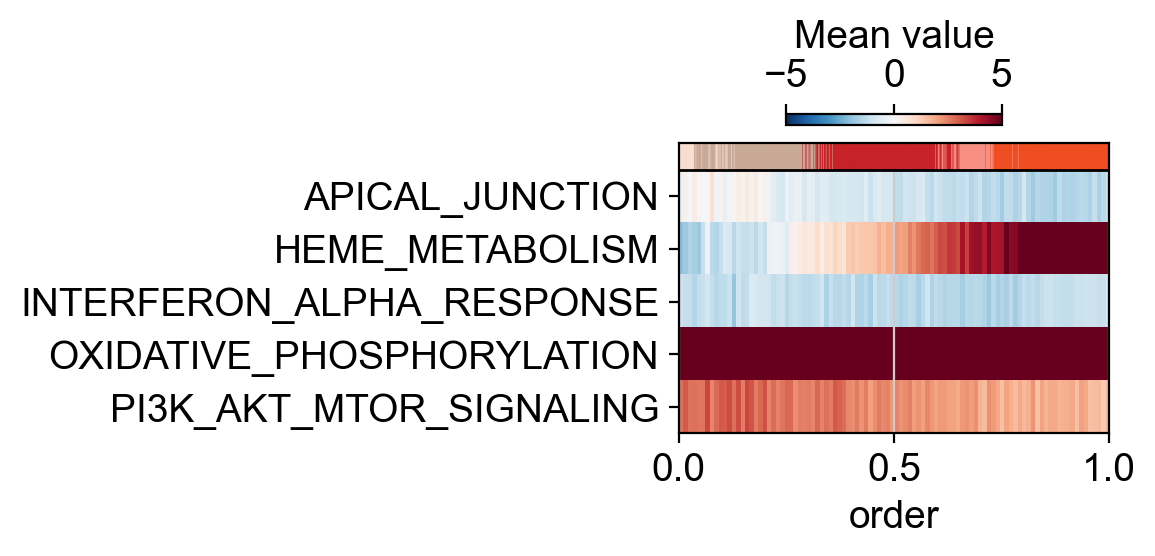

In [32]:
dc.pl.order(
    df=bin_hlm,
    mode='mat',
    kw_order=dict(vmin=-5, vmax=+5, cmap='RdBu_r'),
    figsize=(6, 3)
)